# M1 Coursework - Question 4

In [45]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


from tensorflow.keras.datasets import mnist

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Import MNIST data - as done in Question 1

In [46]:
# Import initial data set from mnist
# x_train_val - will be split into training and validation sets
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()

# Determine how many parameter values are in the data set
num_params = len(np.unique(y_test))

# Normalise the data
x_train_val = x_train_val / 255
x_test = x_test / 255

# Set the data type to float32
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

# Randomly shuffle data to ensure even distribution of labels
# Shuffle 60,000 data set
indices_train_val = np.arange(len(x_train_val))
np.random.shuffle(indices_train_val)
x_train_val = x_train_val[indices_train_val]
y_train_val = y_train_val[indices_train_val]

# Shuffle 10,000 data set
indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

# Split test_val data into training and validation sets()
split_index = int(0.8 * len(x_train_val)) 
# 80 % going to training set
x_train = x_train_val[:split_index] 
y_train = y_train_val[:split_index]
# 20 % going to validation set
x_val = x_train_val[split_index:]
y_val = y_train_val[split_index:]

Item 21816/48000 from x_train
Label: 2


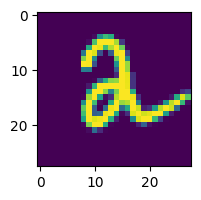

In [47]:
# Print example initial data and labels - randomly selected
plot_index = np.random.randint(0, len(x_train))
print(f"Item {plot_index}/{len(x_train)} from x_train")
print(f'Label: {y_train[plot_index]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train[plot_index])
plt.show()

### Store Upper and Bottom Images Seperately for Sequential Classifier

In [48]:
# Create v stack input data 
train_double_size = 100000
val_double_size = 15000
test_double_size = 15000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices =  [np.random.randint(0, x_train.shape[0], train_double_size), np.random.randint(0, x_train.shape[0], train_double_size)]

val_double_indices =  [np.random.randint(0, x_val.shape[0], val_double_size), np.random.randint(0, x_val.shape[0], val_double_size)]

test_double_indices =  [np.random.randint(0, x_test.shape[0], test_double_size), np.random.randint(0, x_test.shape[0], test_double_size)]


# Generate their corresponding images and labels at these indices

x_train_double = np.concatenate((x_train[train_double_indices[0]], x_train[train_double_indices[1]]), axis=1) 
y_train_double = np.add(y_train[train_double_indices[0]], y_train[train_double_indices[1]])

x_val_double = np.concatenate((x_val[val_double_indices[0]], x_val[val_double_indices[1]]), axis=1)
y_val_double = np.add(y_val[val_double_indices[0]], y_val[val_double_indices[1]])

x_test_double = np.concatenate((x_test[test_double_indices[0]], x_test[test_double_indices[1]]), axis=1)
y_test_double = np.add(y_test[test_double_indices[0]], y_test[test_double_indices[1]])

# Store the top and bottom images individually as these will be used in sequential testing
x_train_double_top = x_train[train_double_indices[0]]
x_train_double_bottom = x_train[train_double_indices[1]]

y_train_double_top = y_train[train_double_indices[0]]
y_train_double_bottom = y_train[train_double_indices[1]]

x_val_double_top = x_val[val_double_indices[0]]
x_val_double_bottom = x_val[val_double_indices[1]]

y_val_double_top = y_val[val_double_indices[0]]
y_val_double_bottom = y_val[val_double_indices[1]]

x_test_double_top = x_test[test_double_indices[0]]
x_test_double_bottom = x_test[test_double_indices[1]]

y_test_double_top = y_test[test_double_indices[0]]
y_test_double_bottom = y_test[test_double_indices[1]]



### Check Images are stored correctly Combined, Top, Bottom for a random sample

100000


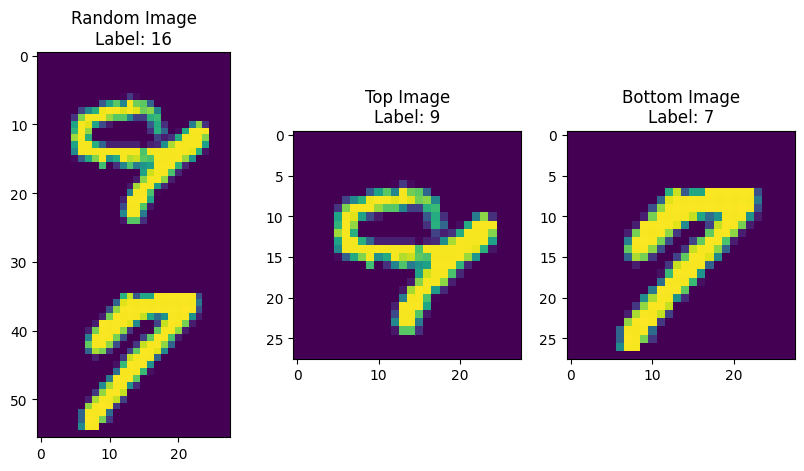

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Select a random index
print(x_train_double.shape[0])
random_index = np.random.randint(0, x_train_double.shape[0])

# Display the images
plt.figure(figsize=(10, 5))

# Random image
plt.subplot(1, 3, 1)
plt.title(f"Random Image\nLabel: {y_train_double[random_index]}")
plt.imshow(x_train_double[random_index])  # Assuming the images are 28x28 and concatenated along axis 1

# Top image
plt.subplot(1, 3, 2)
plt.title(f"Top Image\nLabel: {y_train_double_top[random_index]}")
plt.imshow(x_train_double_top[random_index])

# Bottom image
plt.subplot(1, 3, 3)
plt.title(f"Bottom Image\nLabel: {y_train_double_bottom[random_index]}")
plt.imshow(x_train_double_bottom[random_index])

plt.show()

### Convert all Integer Label to Catagorical Labels

In [50]:
# Use the one-hot encoding for the labels
num_param_single = len(np.unique(y_train))
y_train = to_categorical(y_train, num_param_single)
y_val = to_categorical(y_val, num_param_single)
y_test = to_categorical(y_test, num_param_single)

num_params_double = len(np.unique(y_train_double))
y_train_double = to_categorical(y_train_double, num_params_double)
y_val_double = to_categorical(y_val_double, num_params_double)
y_test_double = to_categorical(y_test_double, num_params_double)

y_test_double_values = np.argmax(y_test_double, axis=1)

## Sequential Classifier - Single Layer Logistic Regression
- The role of the sequential classfier is to classify two 28 X 28 single digit images using a single digit image
- The two output of each classes probability (0,9) can then be convolved to give probability of their addition being (0,19)

### Define the Model
- The base model will simply use a single layer of logistric regression to classify single (28 x 28) digit images and will return 0-9 classification probabilities

In [51]:
# Define input and output shapes
input_shape = x_train.shape[1:]  
output_shape = y_train.shape[1]  # Number of output classes (10 for MNIST)

# Define the logistic regression model for single 28x28 images
model_single = Sequential([
    Input(shape=input_shape),  
    Flatten(),                 
    Dense(output_shape, activation='softmax')
])

# Compile the model with Adam optimizer
model_single.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       
    patience=3,               
    restore_best_weights=True
)

# Save the initial weights so they be resetting after each training
initial_weights_single = model_single.get_weights()

### Define Training and Sequential Result Analysis
- For different training set sizes the model should train the model defined above
- It then should predict the top and bottom images from the test set seperatly
- **Convolve** the probabilities of top and bottom classifications 0-9 to probability of their addition with classification 0-19
- Evaluate the result with the test set to determine accuracy

In [52]:
# Define a function which trains the model with early stopping to be used for different training sizes
# Then preforms the convolution of the two probabilities and calculates the accuracy using the full test set

def train_single_model(train_size):
    # Reset the model to its initial state
    model_single.set_weights(initial_weights_single)

    history = model_single.fit(
        x_train[:train_size], y_train[:train_size],
        validation_data=(x_val, y_val),
        epochs=15,
        batch_size=64,
        callbacks=[early_stopping] 
    )

    predictions_test_top = model_single.predict(x_test_double_top)
    predictions_test_bottom = model_single.predict(x_test_double_bottom)

    # Initialize the combined probabilities for 0–18
    num_samples = predictions_test_top.shape[0]
    combined_test_predictions = np.zeros((num_samples, 19))

    # Convolve probabilities for each sample - combines two probabilities of 0-9 to adding result of 0-18
    for i in range(num_samples):
        combined_test_predictions[i] = np.convolve(predictions_test_top[i], predictions_test_bottom[i])

    # Find the index of the maximum value in the combined probabilities
    combined_test_predictions_value = np.argmax(combined_test_predictions, axis=1)

    # Calculate the accuracy
    accuracy_sequential = accuracy_score(y_test_double_values, combined_test_predictions_value)

    # Generate the classification report as a dictionary
    report_sequential = classification_report(y_test_double_values, combined_test_predictions_value, output_dict=True)

    return model_single, accuracy_sequential, report_sequential, combined_test_predictions_value

### Train the original Training MNIST Data
- The Sequential Classifer is trained on the raw 48,000 set of single images and will return 0-9 classification probabilities
- This is the raw set of unique images, repeated images would cause overfitting - hence why the set of top or bottom images for the double digits values is not used


#### Train for the full data set
- train on the full dataset (48,000)
- save fully trained model to results
- print summary of classification accuracy for all labels
- produce confusion matrix

In [53]:
# Run for the full training set
model_single_full, accuracy_sequential_full, report_sequential_full, combined_test_predictions_value_full = train_single_model(48000)

# Print overall accuracy
print(f"Overall accuracy for full traing: {accuracy_sequential_full:.4f}")

# Save the model in Results folder
model_single_full.save('Results/Logistic_regression_sequential.keras')

# Print a table of accuracy results
table_data_sequential = []
for label, metrics in report_sequential_full.items():
    if label.isdigit():  # Include only class-specific metrics
        table_data_sequential.append([
            int(label),  # Class label
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",
        ])

# Add overall accuracy as a separate row
table_data_sequential.append(["Overall Accuracy", "-", "-", f"{accuracy_sequential_full:.4f}"])

# Create tabulated string
headers = ["Class", "Precision", "Recall", "F1-Score"]
table_sequential_report = tabulate(table_data_sequential, headers=headers, tablefmt="grid")

# Print the table
print(table_sequential_report)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7718 - loss: 0.9153 - val_accuracy: 0.9010 - val_loss: 0.3721
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9018 - loss: 0.3517 - val_accuracy: 0.9117 - val_loss: 0.3226
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9142 - loss: 0.3099 - val_accuracy: 0.9165 - val_loss: 0.3045
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9179 - loss: 0.2902 - val_accuracy: 0.9197 - val_loss: 0.2926
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9195 - loss: 0.2814 - val_accuracy: 0.9199 - val_loss: 0.2910
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9214 - loss: 0.2728 - val_accuracy: 0.9215 - val_loss: 0.2882
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9269 - loss: 0.2635 - val_accuracy: 0.9225 - val_loss: 0.2831
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9266 - loss: 0.2587 - val_accu

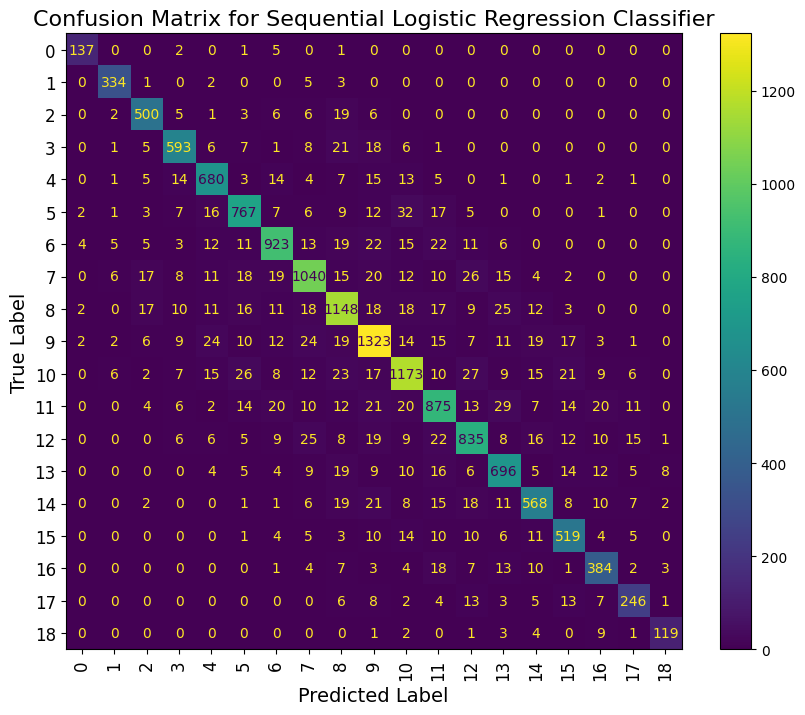

In [54]:
# Generate a confusion matrix
conf_matrix_single = confusion_matrix(y_test_double_values, combined_test_predictions_value_full)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_single, display_labels=np.unique(y_test_double_values))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Sequential Logistic Regression Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Train and Evaluate Sequential Method on Data Set Sizes 50, 100 ,500,1000, 5000, 1000 and 48,000
- Preform the analysis pipeline for various training sizes

In [55]:
# define the training sizes to be used
training_sizes = [50, 100, 500, 1000, 5000, 10000, 48000]

# Store accuracy results in an array
accuracy_sequential = [] 
for size in training_sizes:
    print(f"Training with {size} samples")
    _, accuracy, _, _ = train_single_model(size)  # Call the function with each size
    accuracy_sequential.append(accuracy)  # Append the accuracy to the results array


Training with 50 samples
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1200 - loss: 2.3000 - val_accuracy: 0.1559 - val_loss: 2.3005
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1200 - loss: 2.2537 - val_accuracy: 0.1791 - val_loss: 2.2636
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 2.1730 - val_accuracy: 0.2218 - val_loss: 2.2158
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3600 - loss: 2.0674 - val_accuracy: 0.2614 - val_loss: 2.1609
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4400 - loss: 1.9451 - val_accuracy: 0.2944 - val_loss: 2.1023
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5200 - loss: 1.8133 - val_accuracy: 0.3249 - val_loss: 2.0422
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 1.6781 - val_accuracy: 0.3491 - val_loss: 1.9821
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6600 - loss: 1.5441 - val_accuracy: 0.3764 - val_loss

/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1098 - loss: 2.3079 - val_accuracy: 0.2771 - val_loss: 2.1287
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4577 - loss: 2.0202 - val_accuracy: 0.4175 - val_loss: 1.9354
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5994 - loss: 1.7279 - val_accuracy: 0.4971 - val_loss: 1.7622
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7196 - loss: 1.4578 - val_accuracy: 0.5412 - val_loss: 1.6169
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7767 - loss: 1.2461 - val_accuracy: 0.5645 - val_loss: 1.4985
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8175 - loss: 1.0555 - val_accuracy: 0.5846 - val_loss: 1.3992
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8398 - loss: 0.9120 - val_accuracy: 0.6042 - val_loss: 1.3141
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8679 - loss: 0.7858 - val_accuracy: 0.6256 - val_loss: 1.2388
Epoch 9/15
2/2 ━━━━━━━━━━━━

### Plot the results

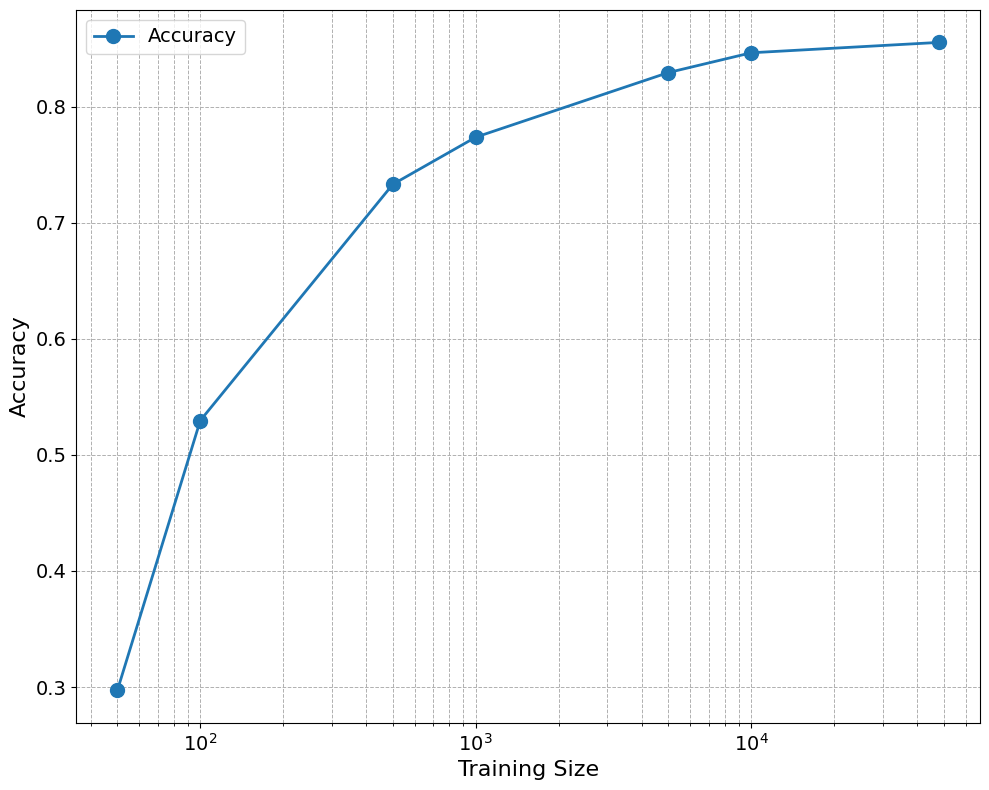

In [56]:
# Plot the trend in accuracy with training size
plt.figure(figsize=(10, 8))
plt.plot(training_sizes, accuracy_sequential, marker='o', linestyle='-', linewidth=2, markersize=10, label='Accuracy')
plt.xscale('log')
plt.xlabel('Training Size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

## Combined Classifer - Single Layer Logistic Regression
- This is more simply a model using a single layer of logistic regression to classify double (56 x 28) digit images and return 0-19 classification probabilities

### Define the model

In [57]:
# Define input and output shapes
input_shape = x_train_double.shape[1:]  
output_shape = y_train_double.shape[1]  # Number of output classes (19 for MNIST)

# Define the logistic regression model for single 28x28 images
model_double = Sequential([
    Input(shape=input_shape),  
    Flatten(),                 
    Dense(output_shape, activation='softmax')
])

# Compile the model with Adam optimizer
model_double.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       
    patience=3,               
    restore_best_weights=True
)

# Save the initial weights so they be resetting after each training
initial_weights_double = model_double.get_weights()

### Define Training and Combined Result Analysis
- For different training set sizes the model should train the model defined above
- Be tested on double/ combined images (56x28) - the same sets as used for sequential
- Evaluate the result with the test set to determine accuracy

In [58]:
def train_double_model(train_size):

     # Reset the model to its initial state
    model_double.set_weights(initial_weights_double)

    # Train the model with early stopping
    history = model_double.fit(
        x_train_double[:train_size], y_train_double[:train_size],
        validation_data=(x_val_double, y_val_double),
        epochs=15,
        batch_size=64,
        callbacks=[early_stopping] 
    )
    y_test_double_pred = model_double.predict(x_test_double)

    # Find the index of the maximum value in the combined probabilities
    y_test_double_pred_value = np.argmax(y_test_double_pred, axis=1)

    # Calculate the accuracy
    accuracy_combined = accuracy_score(y_test_double_values, y_test_double_pred_value)

    # Generate the classification report as a dictionary to be converted to a table
    report_combined = classification_report(y_test_double_values, y_test_double_pred_value, output_dict=True)

    return model_double, accuracy_combined, report_combined, y_test_double_pred_value

### Train using generated MNIST Data
- The Combined Classifer can be trained on the full 100,000 set of generated double training images


#### Train for the 1000 data set
- train on the full dataset (100,000)
- save fully trained model to results
- print summary of classification accuracy for all labels
- produce confusion matrix

In [59]:
# Run for the full training set
model_double_full, accuracy_combined_full, report_combined_full, combined_test_preds_value_full = train_double_model(100000)

# Print overall accuracy
print(f"Overall accuracy for full traing: {accuracy_combined_full:.4f}")

# Save the model in Results folder
model_double_full.save('Results/Logistic_regression_combined.keras')

# Print summary table of classification metrics
table_data = []
for label, metrics in report_combined_full.items():
    if label.isdigit():  # Include only class-specific metrics
        table_data.append([
            int(label),  # Class label
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",])
# Add overall accuracy as a separate row
table_data.append(["Overall Accuracy", "-", "-", f"{accuracy_combined_full:.4f}"])
headers = ["Class", "Precision", "Recall", "F1-Score"]
table_combined_report = tabulate(table_data, headers=headers, tablefmt="grid")
print(table_combined_report)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.1693 - loss: 2.4412 - val_accuracy: 0.2179 - val_loss: 2.2207
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2265 - loss: 2.1982 - val_accuracy: 0.2236 - val_loss: 2.1824
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2408 - loss: 2.1539 - val_accuracy: 0.2302 - val_loss: 2.1809
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2458 - loss: 2.1361 - val_accuracy: 0.2279 - val_loss: 2.1700
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2508 - loss: 2.1208 - val_accuracy: 0.2339 - val_loss: 2.1658
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2543 - loss: 2.1145 - val_accuracy: 0.2211 - val_loss: 2.1776
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2596 - loss: 2.1039 - val_accuracy: 0.2286 - val_loss: 2.1644
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2608 -

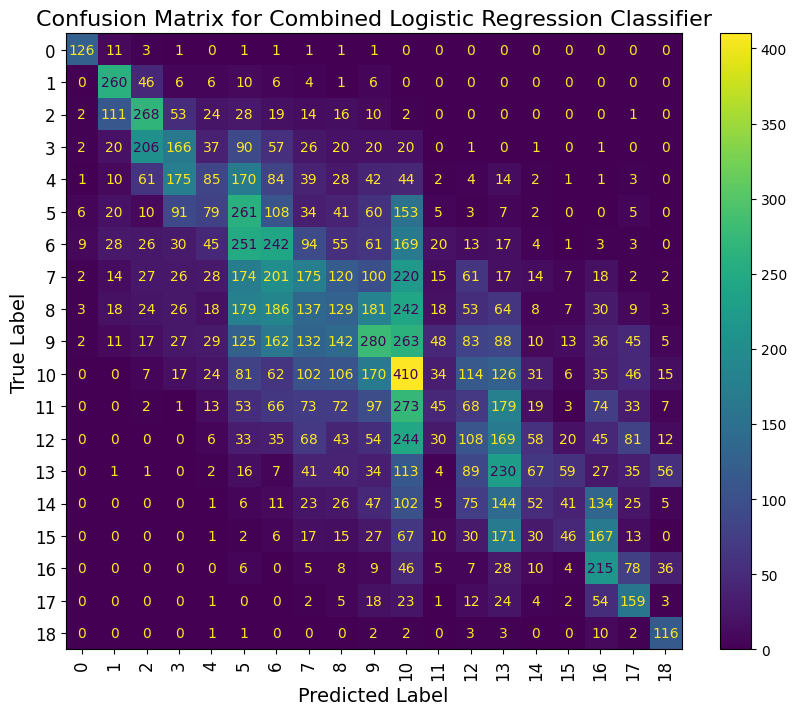

In [60]:
# Generate a confusion matrix
conf_matrix_double= confusion_matrix(y_test_double_values, combined_test_preds_value_full)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_double, display_labels=np.unique(y_test_double_values))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Combined Logistic Regression Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Train and Evaluate Combined Method on Data Set Sizes 50, 100 ,500,1000, 5000, 1000 and 48,000
- These sample sizes are kept inline with the sequential method for fair comparison
- Preform the analysis pipeline for various training sizes

In [61]:
# define the training sizes to be used
training_sizes = [50, 100, 500, 1000, 5000, 10000, 48000]

# Store accuracy results in an array
accuracy_combined = [] 
for size in training_sizes:
    print(f"Training with {size} samples")
    _, accuracy, _, _ = train_double_model(size)  # Call the function with each size
    accuracy_combined.append(accuracy)  # Append the accuracy to the results array

Training with 50 samples
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0600 - loss: 3.0078 - val_accuracy: 0.0673 - val_loss: 2.9929
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0600 - loss: 2.9688 - val_accuracy: 0.0697 - val_loss: 2.9794
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0600 - loss: 2.8999 - val_accuracy: 0.0734 - val_loss: 2.9647
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 2.8092 - val_accuracy: 0.0779 - val_loss: 2.9526
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1200 - loss: 2.7041 - val_accuracy: 0.0809 - val_loss: 2.9463
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1600 - loss: 2.5909 - val_accuracy: 0.0842 - val_loss: 2.9473
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2200 - loss: 2.4745 - val_accuracy: 0.0856 - val_loss: 2.9564
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2800 - loss: 2.3584 - val_accuracy: 0.0860 - val_loss

/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0608 - loss: 2.9585 - val_accuracy: 0.0787 - val_loss: 2.9513
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1098 - loss: 2.7539 - val_accuracy: 0.0885 - val_loss: 2.9219
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1929 - loss: 2.5847 - val_accuracy: 0.0927 - val_loss: 2.9140
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3004 - loss: 2.4200 - val_accuracy: 0.0944 - val_loss: 2.9212
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4496 - loss: 2.2695 - val_accuracy: 0.0982 - val_loss: 2.9367
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5119 - loss: 2.1256 - val_accuracy: 0.0994 - val_loss: 2.9558
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5371 - loss: 2.0021 - val_accuracy: 0.1003 - val_loss: 2.9738
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5808 - loss: 1.8917 - val_accuracy: 0.1027 - val_loss: 2.9850
Epoch 9/15
2/2 ━━━━━━━━━━━━

/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobtutt/Desktop/MPhil_DIS/M1/Coursework_M1/Coursework_M1_Venv/M1_coursework_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.0689 - loss: 2.9623 - val_accuracy: 0.0943 - val_loss: 2.8290
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.1600 - loss: 2.6936 - val_accuracy: 0.1035 - val_loss: 2.7813
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.1999 - loss: 2.5259 - val_accuracy: 0.1127 - val_loss: 2.7499
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.2788 - loss: 2.3590 - val_accuracy: 0.1208 - val_loss: 2.6926
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.3578 - loss: 2.2057 - val_accuracy: 0.1249 - val_loss: 2.6663
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.4406 - loss: 2.1015 - val_accuracy: 0.1296 - val_loss: 2.6527
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.4586 - loss: 2.0246 - val_accuracy: 0.1353 - val_loss: 2.6420
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.5251 - loss: 1.9128 - val_accuracy: 0.1354 - val_loss: 2.6396
Epo

### Plot the results


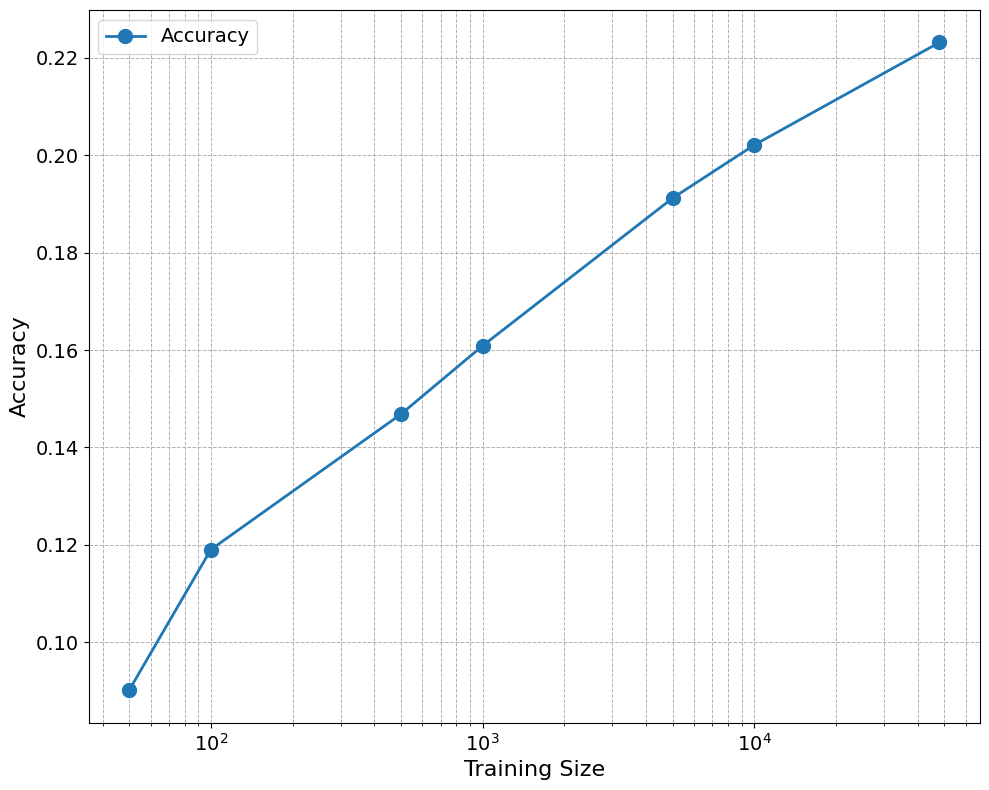

In [62]:
# Plot the trend in accuracy with training size
plt.figure(figsize=(10, 8))
plt.plot(training_sizes, accuracy_combined, marker='o', linestyle='-', linewidth=2, markersize=10, label='Accuracy')
plt.xscale('log')
plt.xlabel('Training Size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()